In [1]:
import pyro
from pyro.infer import MCMC, NUTS, HMC

In [2]:
import os, sys
cwd = os.getcwd()

api_path = os.path.join(cwd, 'tools')
models_path = os.path.join(cwd, 'models_25gaussians')
sys.path.append(api_path)

In [3]:
import numpy as np
import sklearn.datasets
import time
import random

from matplotlib import pyplot as plt

import torch, torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from utils import (Evolution,
                   prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from gan_train import train_gan
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           visualize_fake_data_projection,
                           discriminator_2d_visualization,
                           mh_sampling_visualize,
                           epoch_visualization)
from mh_2d_sampling import mh_sampling

In [4]:
from sklearn.preprocessing import StandardScaler
random_seed = 42
train_dataset_size = 64000
sigma = 0.05

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

X_train, means = prepare_25gaussian_data(train_dataset_size,
                                         sigma, 
                                         random_seed)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [5]:
n_dim = 2
n_layers_g = 4
n_hid_g = 100
n_out = 2

n_layers_d = 4
n_hid_d = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G = Generator_fc(n_dim=n_dim, 
                 n_layers=n_layers_g,
                 n_hid=n_hid_g,
                 n_out=n_out,
                 non_linear=nn.ReLU(),
                 device=device)
D = Discriminator_fc(n_in=n_dim, 
                     n_layers=n_layers_d,
                     n_hid=n_hid_d,
                     non_linear=nn.ReLU(),
                     device=device)

In [6]:
import glob
discriminator_regexp = os.path.join(models_path, "*_discriminator.pth")
generator_regexp = os.path.join(models_path, "*_generator.pth")
discriminator_name = [f for f in glob.glob(discriminator_regexp)][0]
generator_name = [f for f in glob.glob(generator_regexp)][0]

In [7]:
G.load_state_dict(torch.load(generator_name))
D.load_state_dict(torch.load(discriminator_name))

<All keys matched successfully>

In [8]:
epoch = 1000
path_to_save = None
batch_size_sample = 5000  

In [9]:
G = G.to(device)
D = D.to(device)

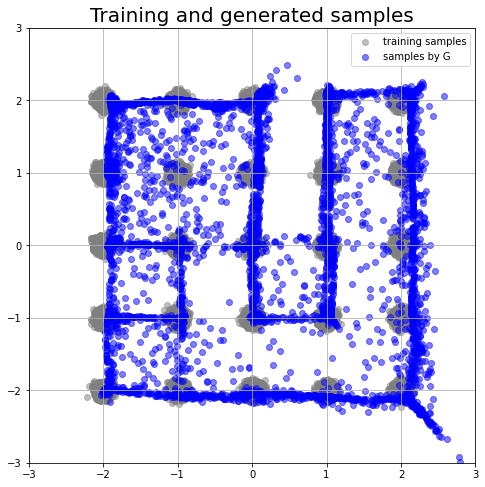

In [10]:
sample_fake_data(G, X_train, epoch, path_to_save, 
                 scaler = scaler,
                 batch_size_sample = batch_size_sample)

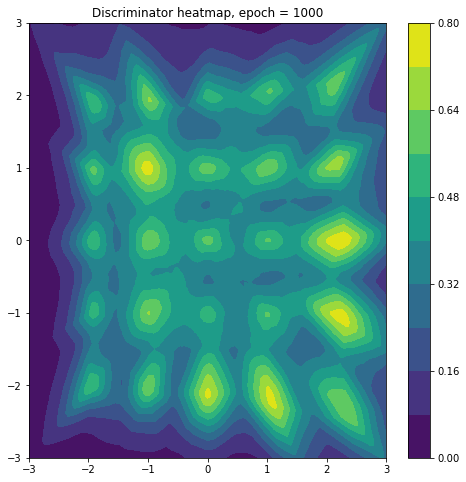

In [11]:
x_range = 3.0
y_range = 3.0
discriminator_2d_visualization(D,
                               x_range,
                               y_range,
                               path_to_save,
                               epoch,
                               scaler = scaler,
                               num_points = 700)

100%|██████████| 5000/5000 [01:06<00:00, 75.50it/s]


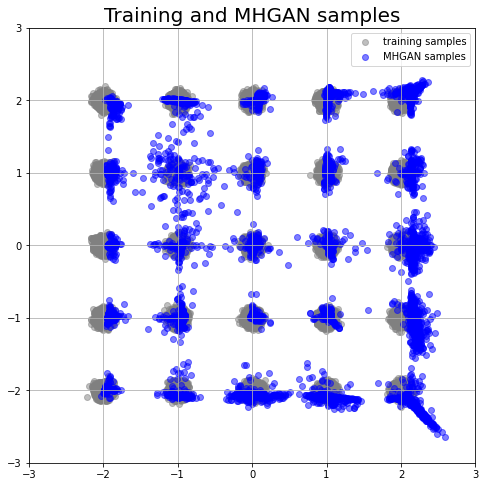

In [12]:
n_calib_pts = 10000
type_calibrator = 'iso'
normalize_to_0_1 = True
mh_sampling_visualize(G, 
                      D,
                      X_train, epoch, 
                      path_to_save,
                      n_calib_pts = n_calib_pts,
                      scaler = scaler, 
                      batch_size_sample = batch_size_sample,
                      type_calibrator = type_calibrator,
                      normalize_to_0_1 = normalize_to_0_1)